# OPENCLASSROOMS - PROJET 9
# PRÉDIRE LA DEMANDE EN ÉLECTRICITÉ
-------------------------------------

## Sommaire


### Mission 1: Correction des données de consommation 

#### I. Présentation et ajustement des données
-  I.1.Consommation mensuelle totale d'électricité
-  I.2.Données météo
-  I.3.Statistiques mensuelles

#### II. Correction des données de consommation selon les données météo
-  II.1.Régression linéaire de la consommation brute selon les DJU
-  II.2.Analyse des résidus
-  II.3.Coefficient de correction
-  II.4.Série temporelle corrigée

### Mission 2: Désaisonnalisation sur les données corrigées

#### I. Moyenne mobile
-  I.1.Fonction de lissage selon une moyenne mobile
-  I.2.Données de consommation corrigées lissées
    
#### II. Des données corrigées aux données lissées
-  II.1.Absorbation des saisonnalités
-  II.2.Projection des données lissées
-  II.3.Décomposition saisonnière

### Mission 3: Prévisions de la consommation électrique

####  I. Préparations à la prédiction
-  I.1.Récapitulatif de nos données actuelles et  nouveaux supports usuels
-  I.2.Fonctions utilitaires

####  II. Méthode de Holt-Winters
-  II.1.Modélisation du lissage exponentiel et analyse du modèle
-  II.2.Prédiction de la consommation
-  II.3.Analyse a posteriori du modèle

####  III. Méthode Seasonnal Auto-Regressive Integrated Moving Average
-  III.1.Stationnarisation
-  III.2.Optimisation des paramètres
-  III.3.Modélisation du processus
-  III.4.Prédiction de la consommation
-  III.5.Analyse a posteriori du modèle
    
####  IV. Comparaison des modèles de Holt-Winters et SARIMA
-  IV.1.Observation des prévisions superposées
-  IV.2.Calcul des indicateurs a posteriori
-  IV.3.Conclusion: Prédiction de la consommation électrique retenue

### Nous importons dans un premier temps l'ensemble des librairies nécessaires pour l'ensemble du projet.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

import scipy.stats as st
from scipy.stats import shapiro

from functions import *
from time import time
from pmdarima import auto_arima
from IPython.display import clear_output
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.stattools, statsmodels.graphics.tsaplots

from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import*
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox

import warnings
warnings.filterwarnings('ignore')

# Mission 1: Correction des données de consommation

# M1.I. Préparation et ajustement des données

### M1.I.1. Consommation mensuelle totale d'électricité

On introduit notre DataFrame principal "df", qui représentera la consommation mensuelles en GWh des Français de janvier 2012 à juin 2020. C'est pourquoi nous restreignons immédiatement le tableau invoqué ici à la France et à la consommation totale en électricité.

In [2]:
df=pd.read_csv("data/projet_9/eco.csv", encoding="latin1", sep="\t")
df=df.loc[df["Territoire"]=="France"].reset_index(drop=True).sort_values("Mois")[["Mois", "Consommation totale"]]
df.columns=["date", "consommation"]; df["date"]=pd.to_datetime(df["date"]); df

,date,consommation
0,2012-01-01,51086
1,2012-02-01,54476
2,2012-03-01,43156
3,2012-04-01,40176
4,2012-05-01,35257
...,...,...
97,2020-02-01,43415
98,2020-03-01,41572
99,2020-04-01,30754
100,2020-05-01,30693


 On affiche maintenant la série temporelle à laquelle nous aurons affaire pour ce projet.

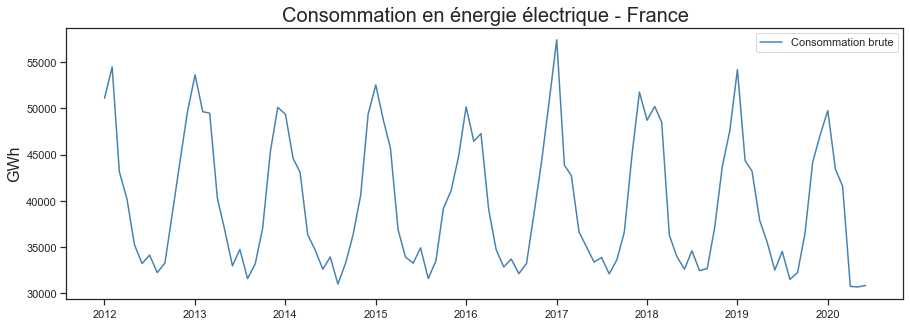

In [3]:
plt.figure(figsize=(15, 5))
plt.plot(df["date"], df["consommation"], label="Consommation brute", color="steelblue")
plt.title("Consommation en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=16), plt.legend()
plt.savefig("data/projet_9/graphiques/M1_I_1_consommation_brute.png"); plt.show()

 On observe alors une tendance stable au fil des années étudiées, ainsi qu'une saisonnalité de 12 mois.

### M1.I.2. Données météo

 Les degrés jours unifiés (DJU), sont des valeurs représentatives de la température d'une journée et de son écart avec un seuil de température préétabli de 18°. Cela nous permet ici de voir si lors d'une période, il a fait plus froid ou non.

In [4]:
dju0=pd.read_excel("data/projet_9/dju.xlsx", header=11).rename(columns={"Unnamed: 0": "year"}).sort_values("year")
dju0=dju0.loc[dju0["year"]>=2012].set_index("year").T.reset_index().rename(columns={"index": "mois"}).head(12); dju0

year,mois,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,JAN,336.0,429.2,324.4,392.0,364.4,467.9,303.4,404.9,339.0
1,FÉV,435.9,402.2,281.9,365.7,321.6,278.4,432.6,268.3,249.6
2,MAR,201.9,376.6,223.9,275.5,321.1,206.1,314.3,233.1,268.6
3,AVR,230.3,209.5,135.5,141.1,212.1,182.6,119.7,168.5,81.4
4,MAI,83.3,158.4,100.2,91.5,88.1,75.0,55.9,117.9,65.7
5,JUN,35.0,43.6,19.1,15.8,27.5,9.4,8.1,24.4,20.6
6,JUI,12.4,0.6,8.3,6.9,5.7,1.0,0.0,0.0,0.0
7,AOÛ,2.4,5.0,19.3,6.1,3.2,6.8,3.3,1.7,0.0
8,SEP,58.0,41.5,16.0,71.9,11.7,62.6,34.3,26.7,0.0
9,OCT,154.6,105.0,92.3,176.9,176.0,99.4,122.4,133.7,0.0


 Nous nous en sortirons mieux si l'on peut superposer nos données. C'est pourquoi nous réajustons le DataFrame précédent sur une seule ligne, ce qui nous permettra de le joindre à df.

In [5]:
# On crée le DataFrame "dju" qui contient les données de "dju0" concaténée sur une seule ligne:
dju=pd.DataFrame(columns=["mois", "conso"])
for i in dju0.columns[1:]:
    data=dju0[["mois", i]]
    m=0
    for j in range(1, 10):
        data.loc[m, "mois"]="%s-0%s" %(i,m+1)
        m+=1
    for k in range(10, 13):
        data.loc[m, "mois"]="%s-%s" %(i,m+1)
        m+=1
    data.columns=["mois", "conso"]
    dju=pd.concat([dju, data])
dju.columns=["date", "dju"]
dju=dju.head(102)
dju["date"]=pd.to_datetime(dju["date"])

# Et on ajoute les données météo à df:
df=pd.merge(df, dju)

# On converti la colonne "date" en datetime:
df["date"]=pd.to_datetime(df["date"])
df=df.set_index("date"); df

,consommation,dju
date,,
2012-01-01,51086,336.0
2012-02-01,54476,435.9
2012-03-01,43156,201.9
2012-04-01,40176,230.3
2012-05-01,35257,83.3
...,...,...
2020-02-01,43415,249.6
2020-03-01,41572,268.6
2020-04-01,30754,81.4


### M1.I.3. Statistiques mensuelles

 Présentons les relevés mensuels en France de la consommation électrique au fil des années, que nous superposons avec les DJU.

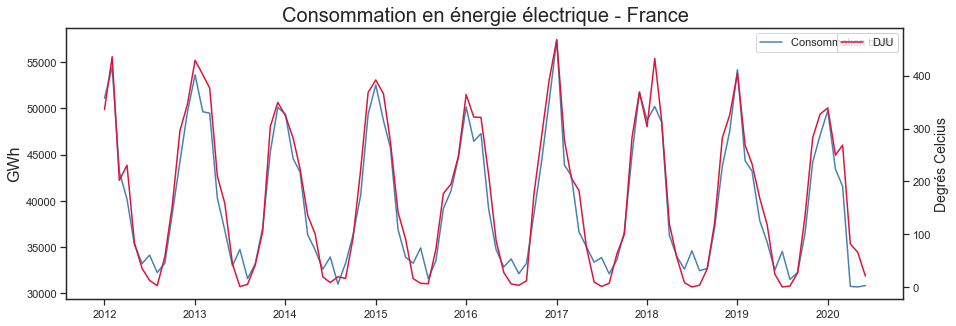

In [6]:
plt.figure(figsize=(15, 5))

plt.plot(df["consommation"], label="Consommation brute", color="steelblue")
plt.ylabel("GWh", fontsize=16), plt.legend()

ax2 = plt.gca().twinx()
plt.plot(df["dju"], label="DJU", color="crimson")
plt.title("Consommation en énergie électrique - France", fontsize=20), plt.ylabel("Degrés Celcius", fontsize=14), plt.legend()
plt.savefig("data/projet_9/graphiques/M1_I_3_DJU.png"); plt.show()

 On observe alors une saisonnalité annuelle. Nous observons logiquement de fortes hausses de la consommation en électricité en hiver (chauffage électrique, lumières...) et des consommations faibles en été. Remarquons que les chiffres de la consommation électrique sont sensiblement superposés avec les DJU, on peut donc fortement supposer une corrélation linéaire entre les deux séries temporelles.

# M1.II. Correction des données de consommation

###  M1.II.1. Régression linéaire de la consommation brute selon les DJU

 Le graphique précédent semble indiquer que les DJU explique une part importante des variations de la série temporelle de la consommation brute au fil des ans. Nous allons donc quantifier la part de consommation expliquée par la température avec une régression linéaire. Dans toute la suite de cette partie, on appellera cette régression linéaire __RL__ dans le codage.

In [7]:
RL=sm.OLS(df["consommation"], sm.add_constant(df[["dju"]].assign(intercept=[1]*len(df)))).fit()
RL.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           consommation   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     1764.
Date:                Mon, 02 Nov 2020   Prob (F-statistic):           2.45e-65
Time:                        19:34:04   Log-Likelihood:                -900.08
No. Observations:                 102   AIC:                             1804.
Df Residuals:                     100   BIC:                             1809.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dju           49.2130      1.172     42.002      0.000      46.888      51.538
intercept   3.137e+04    261.348    120.037      0.000    3.09e+04    3.19e+04
==============================================================================
Omnibus:                        0.105   Durbin-Watson:                   1.617
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.100
Skew:                          -0.066   Prob(JB):                        0.951
Kurtosis:                       2.923   Cond. No.                         354.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

 On relève de cette régression linéaire:
- Une F-statistic proche de 0 et les pvalues de 0 pour les t-tests effectués sur les coefficients.
- Un R² de 0,948.

Ainsi, le modèle paraît significatif et indique que __les DJU explique environ 94,8% de la variance de la consommation électrique__. Déterminons alors le diagramme de dispersion entre les DJU et la consommation électrique, la droite de régression linéaire de ce diagramme, ainsi que le coefficient de corrélation de Pearson afin de manifester la forte corrélation entre ces deux variables quantitatives.

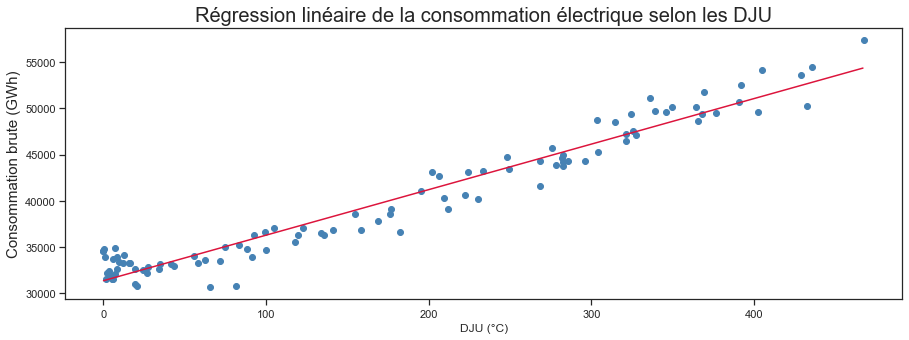

Coefficient de corrélation de Pearson: 0.9728087246876254   p_value: 2.445196230580705e-65


In [8]:
plt.figure(figsize=(15, 5))

# Affichage du nuage de dispersion:
fenetre=np.arange(min(df["dju"]), max(df["dju"]))
plt.plot(df["dju"], df["consommation"],  "o", color="steelblue")

# Affichage de la droite de régression linéaire:
a, b=RL.params["dju"], RL.params["intercept"]
plt.plot(fenetre, [a*x+b for x in fenetre], color="crimson")

plt.title("Régression linéaire de la consommation électrique selon les DJU", fontsize=20)
plt.xlabel("DJU (°C)", fontsize=12), plt.ylabel("Consommation brute (GWh)", fontsize=15)
plt.savefig("data/projet_9/graphiques/M1_II_1_a_Regression_lineaire_cons_dju.png"); plt.show()

# On affichera juste en-dessous le coefficient de corrélation de Pearson de ces deux variables et sa p_value:
pearson, p_value = st.pearsonr(df["dju"], df["consommation"])[0], st.pearsonr(df["dju"], df["consommation"])[1]
print("Coefficient de corrélation de Pearson:", pearson, " ", "p_value:", p_value)

 Cette régression linéaire montre bien que l'on peut conserver un modèle fiable en corrigeant les données de consommation électrique par les DJU.

### M1.II.2. Analyse des résidus

En vue des analyses répétées que nous exécuterons sur les __résidus des modélisations__ à venir, nous créons ici les fonctions décrites ci-dessous qui prendront toutes en entrée une modélisation donnée pour renvoyer un certain résultat sur ses résidus. __Nous réutiliserons ces fonctions pour la mission 3__.
    
- 1°) __"residus_henry"__: qui nous superposera les résidus d'une modélisation donnée avec la droite de Henry.
- 2°) __"nuage_residuel"__: qui nous renverra le nuage de la variance résiduelle.
- 3°) __"analyse_des_residus"__: qui nous renverra d'une traite ces deux derniers graphiques. 

In [9]:
# 1°) Droite de Henry:
def residus_henry(MODEL, nom, couleur, ax):
    sm.qqplot(MODEL.resid, ax=ax, line="45", fit=True, color=couleur)
    ax.set_title("Droite de Henry - Résidus de %s" %nom, fontsize=18)
    ax.set_xlabel("Quantiles théoriques" ,fontsize=16), ax.set_ylabel("Quantiles observés", fontsize=16)
    
# 2°) Nuage de la variance résiduelle:
def nuage_residuel(MODEL, nom, couleur, ax):
    ax=plt.plot(MODEL.fittedvalues, MODEL.resid, ".", color=couleur, alpha=0.3)
    plt.title("Nuage de la variance résiduelle de %s" %nom, fontsize=18)
    plt.xlabel("GWh", fontsize=16), plt.ylabel("Résidus", fontsize=16)
    
# 3°) Les deux en même temps:
def analyse_des_residus(MODEL, nom, couleur):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    residus_henry(MODEL, nom, couleur, ax1)
    nuage_residuel(MODEL, nom, couleur, ax2)

 On applique maintenant ces fonctions sur la régression linéaire en vue de l'analyse des résidus.

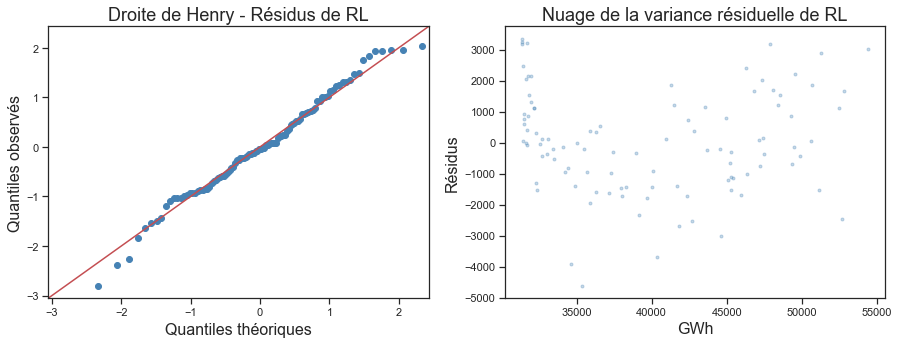

In [10]:
analyse_des_residus(RL, "RL", "steelblue")
plt.savefig("data/projet_9/graphiques/M1_II_1_residus_reg_lineaire.png"); plt.show()

 Les résidus sont sensiblement alignés sur la droite de Henry. On en déduit qu'ils sont sensiblement en adéquations avec la loi Gaussienne. La régression linéaire de la consommation électrique selon les DJU est donc fiable. Nous utiliserons scipy.stats pour déterminer les coefficients de correction afin d'en obtenir un spécifique pour chaque mois tout au long des années étudiées.

### M1.II.3. Coefficient de correction

 Intéressons-nous au coefficient des degrés de jours unifiés de la régression linéaire effectuée.

In [11]:
RL.params["dju"]

49.21303665940665

 On relève le coefficient de correction des DJU de cette régression linéaire et nous pouvons ajouter à df les données corrigées par les DJU. Nous aurons ainsi les données de la consommation électrique qui ne sont pas liées à l'effet température (chauffage, éclairage...).

In [12]:
df["consommation_corrigee"]=df["consommation"]-df["dju"]*RL.params["dju"] ; df

,consommation,dju,consommation_corrigee
date,,,
2012-01-01,51086,336.0,34550.419682
2012-02-01,54476,435.9,33024.037320
2012-03-01,43156,201.9,33219.887898
2012-04-01,40176,230.3,28842.237657
2012-05-01,35257,83.3,31157.554046
...,...,...,...
2020-02-01,43415,249.6,31131.426050
2020-03-01,41572,268.6,28353.378353
2020-04-01,30754,81.4,26748.058816


### M1.II.4. Série temporelle corrigée

 Nous allons maintenant observer les consommations corrigées par les DJU, en les superposant avec les données initiales.

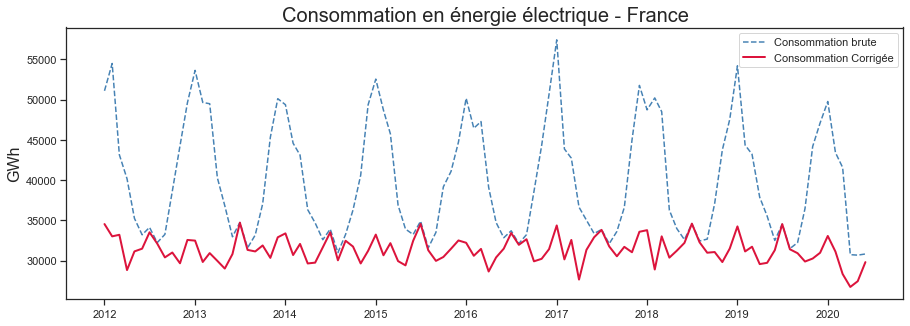

In [13]:
plt.figure(figsize=(15,5))

# Superposition de la consommation brute et de la consommation corrigée:
plt.plot(df["consommation"], color="steelblue", linestyle="dashed", label="Consommation brute", linewidth=1.5)
plt.plot(df["consommation_corrigee"], color="crimson", label="Consommation Corrigée", linewidth=2)

plt.title("Consommation en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=16), plt.legend()
plt.savefig("data/projet_9/graphiques/M1_II_3_a_consommation_electrique.png") ; plt.show()

 On observe alors une nouvelle série temporelle bien moins régulière. La correction des données de consommation par les DJU inhibe les effets de température sur la dite série: nous n'observons plus les maximums locaux en hiver et les minimums locaux en été. Observons de plus près la série temporelle de la consommation corrigée obtenue.

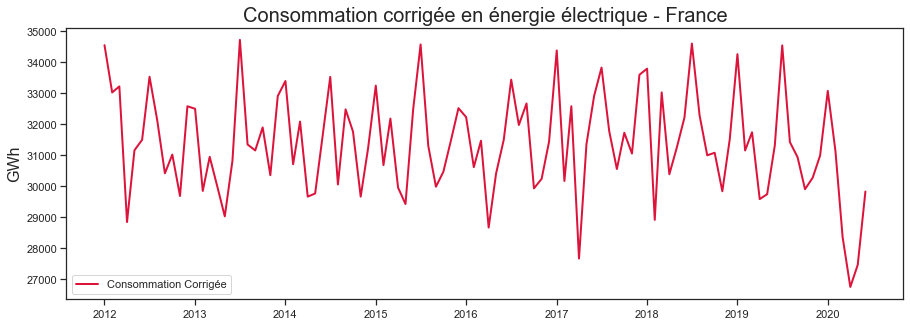

In [14]:
plt.figure(figsize=(15,5))
plt.plot(df["consommation_corrigee"], color="crimson", label="Consommation Corrigée", linewidth=2)
plt.title("Consommation corrigée en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=16), plt.legend()
plt.savefig("data/projet_9/graphiques/M1_II_3_b_consommation_corrigee.png") ; plt.show()

 En zoomant sur la consommation corrigée du deuxième graphique, on observe une nouvelle saisonnalité. En effet, alors que la consommation brute présentait une saisonnalité de 12 mois, la consommation corrigée, elle, présente des pics réguliers environ deux fois par an, soit tous les 6 mois. Nous observons cependant toujours une périodicité de 12 mois, en remarquant que le maximum observé de la consommation s'effectue chaque année au même moment (en hiver), et le minimum aux alentours du mois d'août. Analysons les variations des maximums et minimums locaux par année de cette série afin de choisir le type de modèle que nous utiliserons.

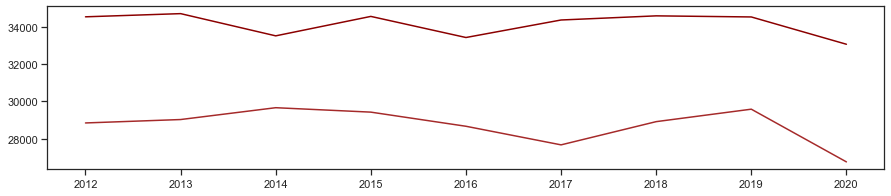

In [15]:
MAX_YEARS, MIN_YEARS = [], []
for i in range(0, 102, 12):
    rest=df.iloc[i:i+12]
    maxi, mini = max(rest["consommation_corrigee"]), min(rest["consommation_corrigee"])
    MAX_YEARS.append(maxi), MIN_YEARS.append(mini)    
years=pd.DataFrame({"MAXI": MAX_YEARS, "MINI": MIN_YEARS}, index=range(2012, 2021))

plt.figure(figsize=(15, 3))
plt.plot(years.MAXI, color="darkred"), plt.plot(years.MINI, color="brown") ; plt.show()

 Les courbes ne se superposent pas parallèlement mais l'ampliture des périodes ne semble pas varier avec le temps. On choisira donc un modèle additif pour les décompositions et prédictions à venir.

# Mission 2: Désaisonnalisation des données corrigées

# M2.I. Lissage des données corrigées

### M2.I.1. Moyenne mobile

Nous créons ici une fonction qui prend en entrée une série temporelle S et un entier p, et qui nous renvoie la série lissée en moyenne mobile Mp, en conservant son indexation initiale.

In [16]:
def lissage(S, p):
    P=S[p: -p].index
    L=[]
    for i in range(p, len(S)-p):
        L.append(np.mean(S[i-p: i+p]))
    return(pd.Series(L, index=P))

### M2.I.2. Données de consommation corrigées lissées

 La périodicité de notre série temporelle étant de 12 (pour les douze mois de l'année), nous prendrons la moyenne mobile M12 sur nos données corrigées. Nous créons ici le DataFrame "lisses" qui contient les données de consommation corrigées de df, lissées par M12.

In [17]:
df["consommation_lissee"]=lissage(df["consommation_corrigee"], 12) ; df.head(50).tail(5)

,consommation,dju,consommation_corrigee,consommation_lissee
date,,,,
2015-10-01,39170,176.9,30464.213815,31412.563644
2015-11-01,41085,195.0,31488.457851,31336.308178
2015-12-01,44727,248.1,32517.245605,31360.290624
2016-01-01,50161,364.4,32227.769441,31368.948347
2016-02-01,46440,321.6,30613.087410,31416.228786


# M2.II. Des données corrigées aux données lissées

### M2.II.1. Absorbation des saisonnalités

  On visualise maintenant les données lissées sous M12 de la consommation en électricité en France que l'on superpose avec les données corrigées.

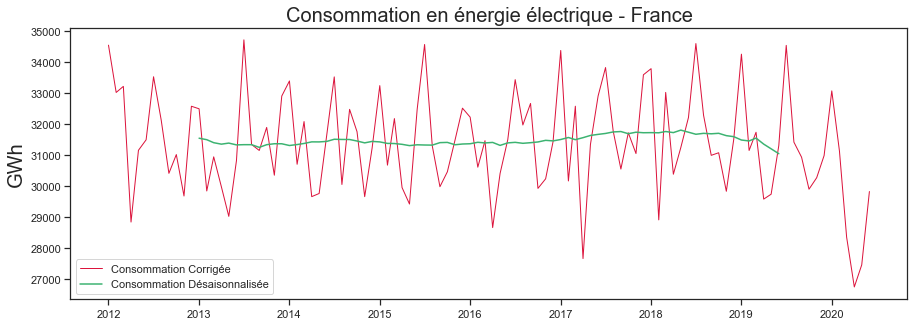

In [18]:
plt.figure(figsize=(15,5))
plt.plot(df["consommation_corrigee"], color="crimson", label="Consommation Corrigée", linewidth=1)
plt.plot(df["consommation_lissee"], color="mediumseagreen", label="Consommation Désaisonnalisée")

plt.title("Consommation en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M2_II_1_donnees_lissees.png") ; plt.show()

 Sur la courbe verte, nous observons bien une série temorelle dépourvue de saisonnalité.

### M2.II.2. Projection des données lissées

 Puis on observe la projection de la consommation désaisonnalisée dans un tableau agrandi.

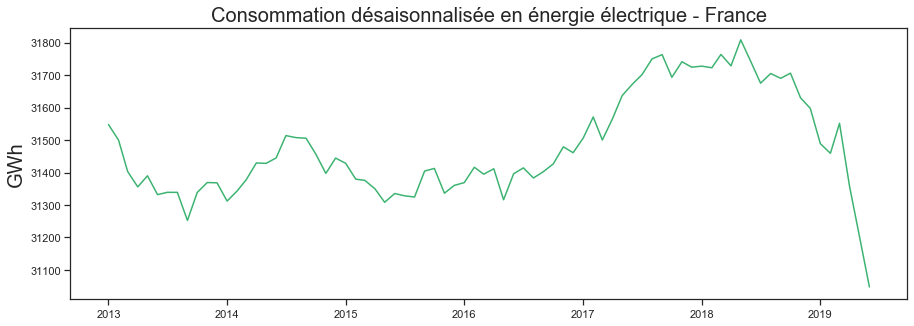

In [19]:
plt.figure(figsize=(15,5))
plt.plot(df["consommation_lissee"], color="mediumseagreen", label="Consommation Désaisonnalisée")
plt.title("Consommation désaisonnalisée en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=20)

plt.savefig("data/projet_9/graphiques/M2_II_2_desaisonnalisees.png") ; plt.show()

 Observons que nous ne pouvons plus justifier une seule saisonnalité régulière, ni la moindre tendance: la chute drastique à partir de 2019 est précédée du maximum global de la série, lui-même précédé d'une oscillation approximative autour du seuil de 31400 GWh.

### M2.II.3. Décomposition saisonnière

 On décompose la tendance, la saisonnalité et les résidus de la consommation corrigée.

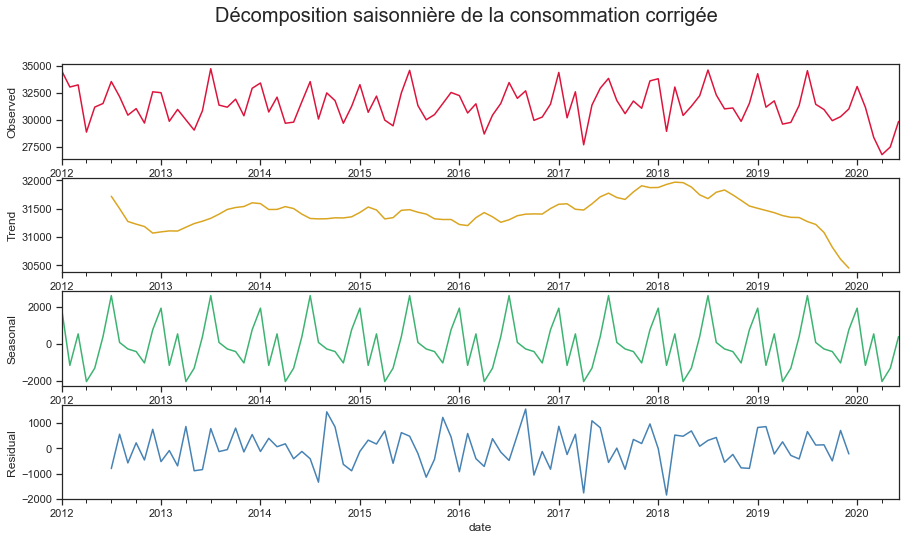

In [20]:
sd=seasonal_decompose(df["consommation_corrigee"],  model="additive") # Décomposition saisonnière

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 8))

sd.observed.plot(ax=ax1, color="crimson") # Valeurs observées
sd.trend.plot(ax=ax2, color="goldenrod") # Tendance
sd.seasonal.plot(ax=ax3, color="mediumseagreen") # Saisonnalité
sd.resid.plot(ax=ax4, color="steelblue") # Résidus

ax1.set_ylabel("Observed") ; ax2.set_ylabel("Trend") ; ax3.set_ylabel("Seasonal") ; ax4.set_ylabel("Residual")
plt.suptitle("Décomposition saisonnière de la consommation corrigée", fontsize=20)
plt.savefig("data/projet_9/graphiques/M2_II_3_decomposition.png") ; plt.show()

 Nous observons notamment sur la courbe bleue des résidus distribués normalement autour d'une moyenne proche de 0 avec une variance proche de 1. On en déduit la fiabilité du modèle. La courbe verte semble montrer une saisonnalité d'environ une demi-année, soit 6 mois. Observons-le sur un diagramme d'autocorrellation.

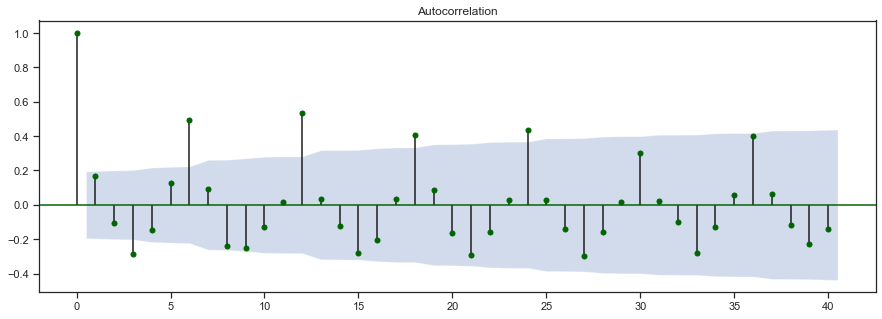

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,5)) 
plot_acf(df['consommation_corrigee'], ax=ax, lags=40, color="darkgreen")
plt.savefig("data/projet_9/graphiques/M2_II_3_saisonnalite.png") ; plt.show()

 Les points sortant du nuage semblent s'étaler sur 6 périodes. On peut donc en déduire une saisonnalité de 6 mois pour les données corrigées.

# Mission 3: Prévisions de la consommation électrique

# M3.I. Préparations à la prédiction

### M3.I.1. Récapitulatif de nos données actuelles et nouveaux supports usuels

Jusqu'ici, nous avons récolté dans df:
- ["consommation"]: Les consommations brutes prélevées chaque mois de janvier 2012 à juin 2020 en kWh.
- ["dju"]: Les degrés de jours unifiés (DJU) en degré Celcius.
- ["consommation_corrigee"]: Les consommations brutes corrigées par les DJU.
- ["consommation_lissee"]: Les consommations corrigées par les DJU lissées par les moyennes mobiles.

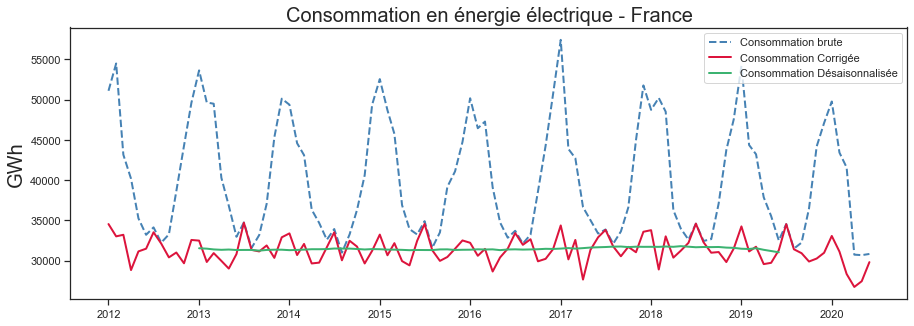

In [22]:
plt.figure(figsize=(15,5))
plt.plot(df["consommation"], color="steelblue", linestyle="dashed", label="Consommation brute", linewidth=2)
plt.plot(df["consommation_corrigee"], color="crimson", label="Consommation Corrigée", linewidth=2)
plt.plot(df["consommation_lissee"], color="mediumseagreen", label="Consommation Désaisonnalisée", linewidth=2)
plt.title("Consommation en énergie électrique - France", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_I_1_recapitulatif.png") ; plt.show()

 Nous effectuerons les modèles de prédiction sur les données de la __consommation corrigée__ et nous analyserons leur performance avec des analyses a posteriori sur les 12 derniers mois observés. C'est pourquoi nous définissons "df_tronc" et "df_a_prevoir", respectivement les données de la consommation corrigée de df sur les 90 premiers mois étudiés (janvier 2012 - juin 2019 inclus) et celles sur les 12 derniers mois observés (juillet 2019 - juin 2020 inclus).

In [23]:
df_tronc=df[["consommation_corrigee"]].head(90)
df_a_prevoir=df[["consommation_corrigee"]].tail(12)

dates_tronc=df_tronc.index
dates_a_prevoir=df_a_prevoir.index

dates_a_prevoir

DatetimeIndex(['2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01'],
              dtype='datetime64[ns]', name='date', freq=None)

 Nous créons également l'index "futur" qui nous renvoie les 12 dates de l'année à venir (juillet 2020 - juin 2021) convertis en datetime.

In [24]:
futur=[]
for i in range(7, 13):
    if i<10:
        j="2020-0%s-01" %i
    else: j="2020-%s-01" %i
    futur.append(j)
for i in range(1, 7):
    j="2021-0%s-01" %i
    futur.append(j)
    
futur=pd.to_datetime(futur) ; futur

DatetimeIndex(['2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
               '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01'],
              dtype='datetime64[ns]', freq=None)

### M3.I.2. Fonctions utilitaires

 Dans le cadre des modélisations et des prédictions à venir, nous allons établir les cinq fonctions suivantes que nous utiliserons régulièrement:
- __1°)__  Nous créons la fonction __model_HW__  qui prendra en argument une certaine restriction des données corrigées (ou bien l'ensemble de ces données), et en modélisera le lissage exponentiel avec une saisonnalité de 6 (saisonnalité déterminée dans la mission précédente).  
    
    
-  __2°)__  La fonction  __prediction_HW__  prendra en argument un modèle de lissage exponentiel donné et nous renverra directement la prédiction des formules de mise à jour de ces données pour la méthode de Holt-Winters sur les 12 mois à venir.
    
    
-  __3°)__  La fonction  __serie_predite__  nous renverra la série des prédictions réalisées par la méthode de Holt-Winters, indexée par les dates en vigueur.
    
    
-  __4°)__  Nous utiliserons la fonction  __differenciation__  qui prendra en argument une série et un entier n, puis nous renverra la série en question différenciée de n. Nous l'utiliserons pour la stationnarisation des données corrigées de consommation dans le cadre des prédictions selon le modèle SAMIRA.
    
    
-  __5°)__  La fonction  __resultats_dickey_fuller__  prendra en argument un test de Dickey-Fuller donné (que l'on utilisera essentiellement sur les données de consommation corrigées et leurs différenciations) et nous affichera directement sa pvalue ainsi que ses valeurs critiques.

In [25]:
# 1°) Modèle de Holt-Winters:
def model_HW(data):
    return(ExponentialSmoothing(np.asarray(data["consommation_corrigee"]),
                                seasonal_periods=6, trend="add", seasonal="add").fit())

# 2°) Prédiction de Holt-Winters sur 12 mois:
def prediction_HW(HW): 
    return(HW.forecast(12))

# 3°) Série prédite pour la prédiction de Holt-Winters:
def serie_predite(array, ind):
    return(pd.Series(array, index=ind))

# 4°) Fonction de différenciation pour la stationnarisation:
def differenciation(serie, n):
    diff=serie - serie.shift(n)
    return(diff.dropna())

# 5°) Affichage des résultats d'un test de Dickey-Fuller sur une série temporelle donnée:
def resultats_dickey_fuller(serie):
    AF=adfuller(serie)
    print("Pvalue du test de Dickey-Fuller:", AF[1])
    print("Statistique de test:", AF[0])
    print("Valeurs Critiques:")
    for key, value in AF[4].items():
        print('\t%s: %.3f' % (key, value))

# M3.II. Méthode de Holt-Winter

### M3.II.1. Modélisation du lissage exponentiel et analyse du modèle

Nous utilisons ici la méthode de Holt-Winter pour prédire la consommation électirique d'ici juin 2021. Nous modélisons ici le lissage exponentiel double sur les données de consommations corrigées que nous appellerons "hw_conso", ainsi que les prédictions du modèle que nous appellerons "hw_pred".

In [26]:
# Modélisation du lissage exponentiel et prédiction du modèle sur les 12 mois à venir:
hw_conso=model_HW(df)
hw_pred=prediction_HW(hw_conso)

# Série indexée par les dates futures des prédictions et ajout de la valeur donnée du 6 juin 2020 pour lier les données:
hw_serie=serie_predite(hw_pred, futur)
hw_serie["2020-06-01"]=df.loc["2020-06-01", "consommation_corrigee"]
hw_serie.index=pd.to_datetime(hw_serie.index)
hw_serie=hw_serie.sort_index()

hw_conso.summary()

Dep. Variable:,endog,No. Observations:,102
Model:,ExponentialSmoothing,SSE,139366065.545
Optimized:,True,AIC,1461.019
Trend:,Additive,BIC,1487.269
Seasonal:,Additive,AICC,1464.525
Seasonal Periods:,6,Date:,"Mon, 02 Nov 2020"
Box-Cox:,False,Time:,19:34:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1052632,alpha,True
smoothing_slope,0.1052632,beta,True


 On vérifie la fiabilité de notre modèle en analysant l'adéquation des résidus à la loi gaussienne sur la droite de Henry, ainsi que leur homoscédasticité sur le nuage de la variance résiduelle.

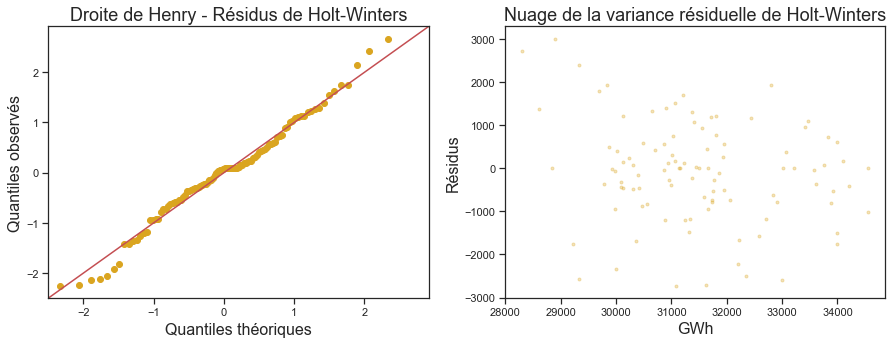

In [27]:
analyse_des_residus(hw_conso, "Holt-Winters", "goldenrod")
plt.savefig("data/projet_9/graphiques/M3_II_1_residus_holt_winters.png") ; plt.show()

 La modélisation semble fiable. En effet, on observe un bon alignement des résidus sur la droite de Henry, on en déduit alors que leur distribution est sensiblement normale, et une concentration centrée de leurs variances sur le nuage résiduel.

### M3.II.2. Prédiction de la consommation

 On affiche maintenant la consommation prédite par le modèle "hw_conso" par la méthode de Holt-Winters.

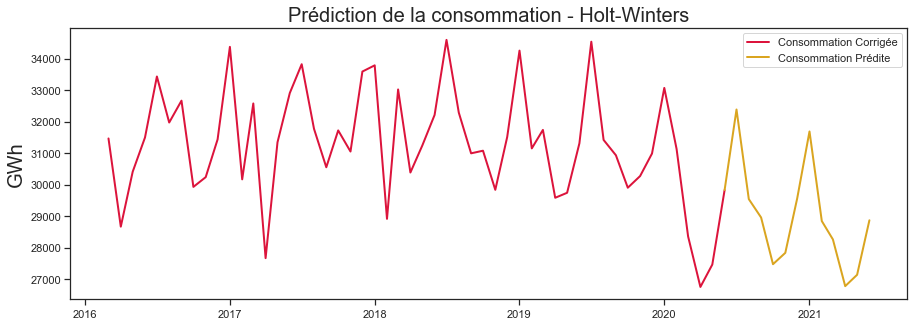

In [28]:
plt.figure(figsize=(15,5))

# Affichage des données de consommation corrigées (à partir de 2016 pour une meilleure visualisation de la prédiction):
plt.plot(df["consommation_corrigee"][50:], color="crimson", label="Consommation Corrigée", linewidth=2)

# Affichage de la prédiction selon la méthode de Holt-Winters:
plt.plot(hw_serie, color="goldenrod", label="Consommation Prédite", linewidth=2)

plt.title("Prédiction de la consommation - Holt-Winters", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_II_2_prediction_holt_winters.png") ; plt.show()

 La méthode de Holt-Winters semble avoir prédit une saisonnalité correcte, mais une tendance légèrement décalée.

### M3.II.3. Analyse a posteriori du modèle

 Pour avoir un aperçu de la prédiction précédente, nous allons analyser ce que ce même modèle aurait prédit pour cette année, en superposant ce graphique avec les valeurs réelles.

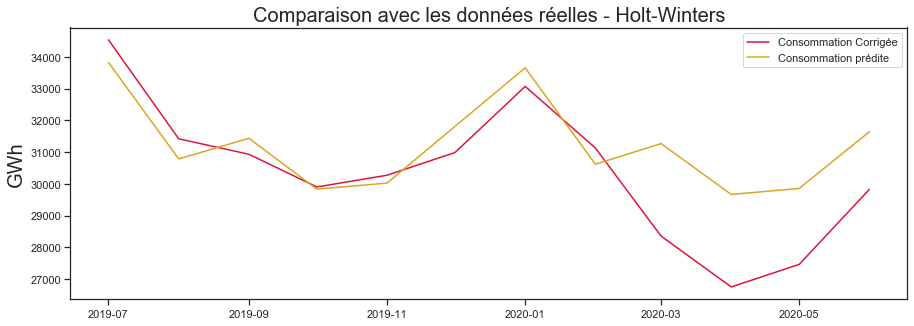

In [29]:
plt.figure(figsize=(15,5))

hw_conso_tronc=model_HW(df_tronc)
hw_posteriori=prediction_HW(hw_conso_tronc)
hw_posteriori_serie=serie_predite(hw_posteriori, dates_a_prevoir)

plt.plot(df_a_prevoir, color="crimson", label="Consommation Corrigée")
plt.plot(hw_posteriori_serie, color="goldenrod", label="Consommation prédite")

plt.title("Comparaison avec les données réelles - Holt-Winters", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_II_3_posteriori_holt_winters.png") ; plt.show()

 La prédiction semble s'éloigner de la réalité sur le long terme. C'est pourquoi on peut estimer que la méthode de Holt-Winters ne permet une prédiction que sur un court terme, d'environ 8 mois si l'on se référencie au graphique ci-dessus.

# M3.III. Méthode Seasonnal Auto-Regressive Integrated Moving Average

### M3.III.1. Stationnarisation

 Un processus stochastique est dit stationnaire si :
- L'esperance et la variance sont constantes avec le temps.
- Les autocorélations entre deux moments séparés dans le temps sont constantes.

La question est de savoir si les données corrigées par la température représentent une série temporelle stationnaire. Pour cela, on observe graphiquement la stationnarité de cette série et on effectue un test de Dickey-Fuller.

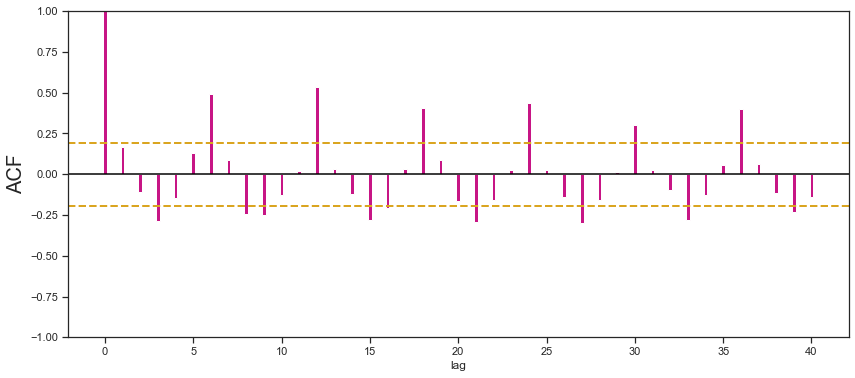

Pvalue du test de Dickey-Fuller: 1.2347172923357133e-13
Statistique de test: -8.501508319425254
Valeurs Critiques:
	1%: -3.497
	5%: -2.891
	10%: -2.582


In [30]:
# Affichage des autocorrélogrammes des données de consommation corrigées:
plot_sortie_acf(acf(np.asarray(df["consommation_corrigee"])), len(df))

# Test de Dickey-Fuller sur les données de consommation corrigées:
resultats_dickey_fuller(df["consommation_corrigee"])

 La statistique de test est sensiblement éloignée des valeurs critiques et la pvalue du test indique que le modèle n'est pas stationnaire. C'est pourquoi nous allons effectuer la différenciation  $(I−B)$ .

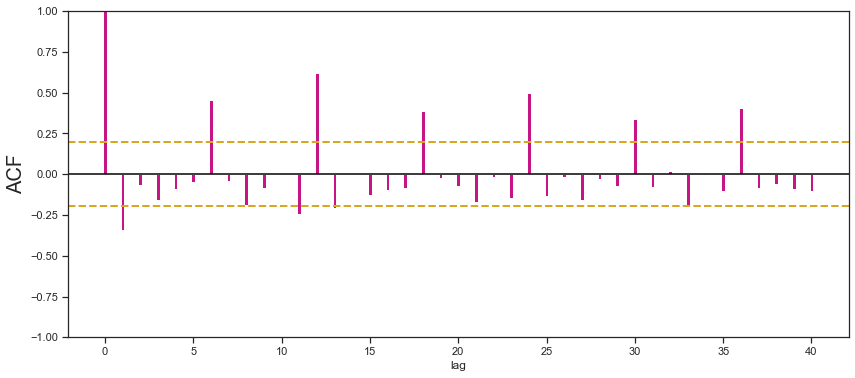

Pvalue du test de Dickey-Fuller: 2.3622606034596986e-26
Statistique de test: -14.127839067473886
Valeurs Critiques:
	1%: -3.498
	5%: -2.891
	10%: -2.582


In [31]:
# Création des données de consommation corrigées différenciées de 1:
diff_1=differenciation(df["consommation_corrigee"], 1)

# Affichage des autocorrélogrammes:
plot_sortie_acf(acf(np.asarray(diff_1)), len(diff_1))

# Test de Dickey-Fuller sur les données différenciées:
resultats_dickey_fuller(diff_1)

 La pvalue du test de Dickey-Fuller est infinitésimalement nulle, cependant nous observons une décroissance faible des autocorrélogrammes et la statistique de test reste éloignée des valeurs critiques. Étant donnée la saisonnalité d'environ 6 observée à la mission 2, nous effectuons la différenciation $(I−B^{6})$.

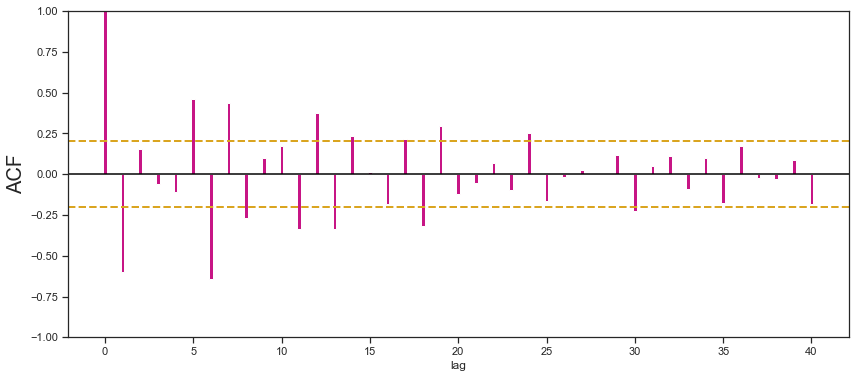

Pvalue du test de Dickey-Fuller: 0.0
Statistique de test: -19.10027290198932
Valeurs Critiques:
	1%: -3.502
	5%: -2.893
	10%: -2.583


In [32]:
# Création des données de consommation corrigées différenciées de 6:
diff_6=differenciation(diff_1, 6)

# Affichage des autocorrélogrammes:
plot_sortie_acf(acf(np.asarray(diff_6)), len(diff_6))

# Test de Dickey-Fuller sur les données différenciées:
resultats_dickey_fuller(diff_6)

 La pvalue du test de Dickey-Fuller proche de 0 nous indique que la série semble également être stationnaire. Cependant les ACF présentent encore des pics significatifs réguliers pour les multiples de 6. Observons alors la différenciation $(I−B^{12})$.

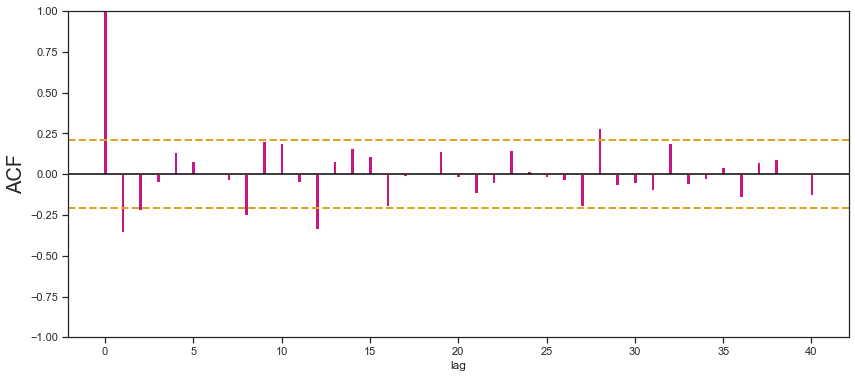

Pvalue du test de Dickey-Fuller: 4.2322243106385515e-25
Statistique de test: -13.418667263824343
Valeurs Critiques:
	1%: -3.507
	5%: -2.895
	10%: -2.585


In [33]:
# Création des données de consommation corrigées différenciées de 12:
diff_12=differenciation(diff_1, 12)

# Affichage des autocorrélogrammes:
plot_sortie_acf(acf(np.asarray(diff_12)), len(diff_12))

# Test de Dickey-Fuller sur les données différenciées:
resultats_dickey_fuller(diff_12)

 Le test de Dickey-Fuller est positif pour la stationnarité de la série. Nous observons que les valeurs significatives de l'ACF ne convergent plus vers 0 et ne présente plus de pics à intervalle régulier significatif au-delà du seuil de 5%, et la statistique de test est proche des valeurs critiques. __La différenciation $(I−B^{12})$ semble alors suffisante pour stationnariser la série__ des données de consommation corrigées par les DJU. On va maintenant s'assurer de la stationnarisation de diff_12 avec les autocorrélogrammes partiels.

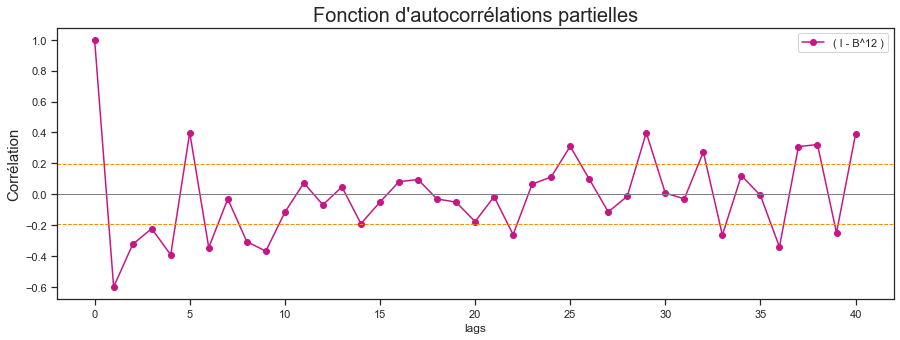

In [34]:
# Autocorrélogrammes partiels de diff_12:
lag_pacf = pacf(diff_6, nlags=40, method="ols")

plt.figure(figsize=(15, 5))

# Affichage des PACF:
plt.plot(lag_pacf, marker="o", color="mediumvioletred", label="( I - B^12 )")

seuil=1.96/np.sqrt(len(df))
plt.axhline(y=seuil, linestyle="--", color="darkorange", linewidth=1)
plt.axhline(y=-seuil, linestyle="--", color="darkorange", linewidth=1)
plt.axhline(y=0, linestyle="-", color="grey", linewidth=1)

plt.title("Fonction d'autocorrélations partielles", fontsize=20)
plt.xlabel("lags"), plt.ylabel("Corrélation", fontsize=15), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_III_1_autocorrelogrammes_partiels.png") ; plt.show()

 Nous n'observons alors bel et bien plus de pics réguliers des ACF.

### <font color="crimson">III.2. Optimisation des paramètres

 Le modèle $SARIMA(p,d,q)(P,D,Q,S)_{s}$  permet de prédire un processus en le décomposant :
- Avec un modèle AR, qui définie une relation linéaire entre un instant t et les  p instants précédents .
- Avec un modèle MA , qui définie une relation entre une perturbation décorélée (un bruit blanc) a un instant t est  les q instants précédents .
- Il fait cette décomposition pour  la partie saisonnière également, selon les paramètres P et Q .
- La stationnarisation de la série est intégrée au modèle,  selon les paramètres d, D et la période s .
    
Nous relevons la saisonnalité de 12 à la vue des résultats de la sous-partie précédente, et l'ordre de la différenciation saisonnière étant de 1, on peut fixer S=12 et D=1. La fonction suivante nous déterminera les meilleurs paramètres à prendre pour p, d, q, P et Q.

In [35]:
stepwise_model=auto_arima(df["consommation_corrigee"], m=12, D=1, seasonal=True, trace=True, error_action="ignore", 
                          suppress_warnings=True, stepwise=True, information_criterion="aic")
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=nan sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1551.369, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1552.841, Time=0.79 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1553.117, Time=0.84 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1551.227, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1551.171, Time=0.97 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=1552.864, Time=1.42 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1552.791, Time=1.94 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1551.259, Time=0.43 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=6.80 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=1553.074, Time=0.47 sec
 ARIMA(1,0,1)(1,1,0)[12] intercept   : AIC=1554.405, Time=1.26 sec
 ARIMA(0,0,0)(1,1,0)[12]             : AIC=1550.688, Time=0.17 sec
 ARIMA(0,0,0)(2,1,0)[12]             : AIC=1552.467, Time=0.48 sec
 ARIMA(0,0,0)(1,1,1)[12]      

### M3.III.3. Modélisation du processus

On estime un modèle $SARIMA(0,0,0)(0,1,1)_{12}$ au vu des autocorrélogrammes empiriques simples et partiels.

In [36]:
SAR=SARIMAX(np.asarray(df["consommation_corrigee"]), order=(0,0,0), seasonal_order=(0,1,1,12)).fit()
print(SAR.summary())

print("Retard : p-value")
for elt in [6, 12, 18, 24, 30, 36]:
    print("{} : {}".format(elt, acorr_ljungbox(SAR.resid, lags=elt)[1].mean()))

                                 SARIMAX Results                                  
Dep. Variable:                          y   No. Observations:                  102
Model:             SARIMAX(0, 1, [1], 12)   Log Likelihood                -772.800
Date:                    Mon, 02 Nov 2020   AIC                           1549.600
Time:                            19:34:57   BIC                           1554.600
Sample:                                 0   HQIC                          1551.617
                                    - 102                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12      -0.0357      0.017     -2.075      0.038      -0.069      -0.002
sigma2      1.796e+06   3.28e+05      5.481      0.000    1.15e+06    2.44e+06
Ljung-Box (Q):      

 Tous les paramètres de SAR sont significatifs au seuil de 5% à la vue des pvalues, toutes infinitésimalement nulles. Testons maintenant la normalité des résidus de cette modélisation. En dépit de la concentration des données, nous n'analyserons pas leur distribution avec une droite de Henry mais avec un test de Shapiro.

In [37]:
sarshap=st.shapiro(SAR.resid)
print("Statistique de test:", sarshap[0], "   ", "Pvalue:", sarshap[1])

Statistique de test: 0.4959964156150818     Pvalue: 4.5230434417746566e-17


 La pvalue du test de Shapiro étant infinitésimalement proche de 0 également, on peut valider la distribution normale des résidus, qui suivent donc un bruit blanc normalement distribué. Enfin, vérifions la robustesse du modèle sur le nuage de la variance résiduelle.

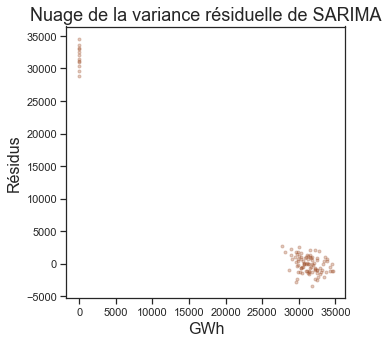

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
nuage_residuel(SAR, "SARIMA", "sienna", ax)
plt.savefig("data/projet_9/graphiques/M3_III_3_variance_residus_SARIMA.png") ; plt.show()

 Nous pouvons à nouveau admettre la fiabilité du modèle, de par la distribution des résidus selon un loi gaussienne et de par leur homoscédasticité. En effet, à l'exception de quelques outliers pour de faibles résidus, la concentration des résidus observée valide la robustesse du modèle SAR.

### M3.III.4. Prédiction de la consommation

 Nous modélisons ici "prediction_SAR", les données prédites par SAR sur l'année à venir (juillet 2020 - juin 2021). Puis nous créons le DataFrame __sarimadata__ qui contiendra ces prévisions moyennes dans une colonne "mean" ainsi que les prévisions basses et hautes au seuil de 5%, respectivement dans les colonnes "inf" et "sup". 

In [39]:
prediction_SAR = SAR.get_forecast(12)
sarimadata=pd.DataFrame({"mean": prediction_SAR.predicted_mean,
                         "inf": [elt[0] for elt in prediction_SAR.conf_int(alpha=0.05)],
                         "sup": [elt[1] for elt in prediction_SAR.conf_int(alpha=0.05)]}, 
                         index=futur) # On rappelle que la liste "futur" établie à la première partie de la mission 3 
sarimadata                            # contient les 1er du mois des 12 mois à venir (juillet 2020 - juin 2021)

,mean,inf,sup
2020-07-01,34544.103499,31917.359240,37170.847759
2020-08-01,31451.618804,28824.874544,34078.363064
2020-09-01,30935.715272,28308.971012,33562.459532
2020-10-01,29944.895583,27318.151323,32571.639843
2020-11-01,30258.322573,27631.578313,32885.066833
2020-12-01,31009.874832,28383.130573,33636.619092
2021-01-01,33116.459978,30489.715718,35743.204238
2021-02-01,31129.374483,28502.630223,33756.118742
2021-03-01,28475.735642,25848.991382,31102.479901
2021-04-01,26850.035105,24223.290846,29476.779365


 Nous allons maintenant afficher ces prévisions effectuées grâce au modèle SARIMA, contenues dans le DataFrame sarimadata.

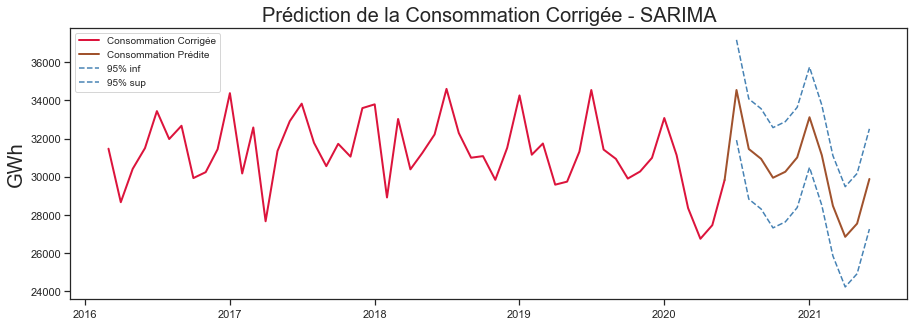

In [40]:
plt.figure(figsize=(15,5))

# Affichage des données de consommation corrigées (à partir de 2016 pour une meilleure visualisation des prévisions):
plt.plot(df["consommation_corrigee"][50:], color="crimson", label="Consommation Corrigée", linewidth=2)

# Jonction des données de consommation et de sa prévision moyenne:
sarimadata.loc['2020-06-01']=(df.loc['2020-06-01', "consommation_corrigee"], np.NaN, np.NaN)
sarimadata.index=pd.to_datetime(sarimadata.index) ; sarimadata=sarimadata.sort_index()

# Affichage des prévisions des données de consommation selon SAR:
plt.plot(sarimadata["mean"], color="sienna", label="Consommation Prédite", linewidth=2)
plt.plot(sarimadata["inf"], color="steelblue", linestyle="--",  label="95% inf")
plt.plot(sarimadata["sup"], color="steelblue", linestyle="--",  label="95% sup")

plt.title("Prédiction de la Consommation Corrigée - SARIMA", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.xlabel("")
plt.legend(loc="upper left", fontsize=10)
plt.savefig("data/projet_9/graphiques/M3_III_4_prediction_sarima.png") ; plt.show()

 Nous observons une prédiction relativement "louable" par la méthode SARIMA. En effet, elle semble correctement suivre les observations des années précédentes. Les prévisions hautes et basses s'alignent également correctement avec les données.

### M3.III.5. Analyse a posteriori du modèle

 Pour avoir un aperçu de la prédiction précédente, nous allons analyser ce que ce même modèle aurait prédit pour cette année, en superposant ce graphique avec les valeurs réelles des données de consommation corrigées.

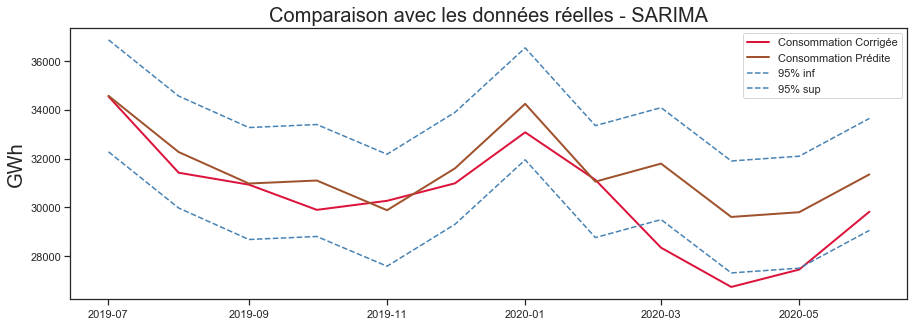

In [42]:
SAR_tronc=SARIMAX(np.asarray(df_tronc["consommation_corrigee"]), order=(0,0,0), seasonal_order=(0,1,1,12)).fit()
prediction_SAR_tronc = SAR_tronc.get_forecast(12)
sarima_previsions=pd.DataFrame({"mean": prediction_SAR_tronc.predicted_mean,
                                "inf": [elt[0] for elt in prediction_SAR_tronc.conf_int(alpha=0.05)],
                                "sup": [elt[1] for elt in prediction_SAR_tronc.conf_int(alpha=0.05)]}, 
                                index=dates_a_prevoir)

plt.figure(figsize=(15, 5))

plt.plot(df_a_prevoir, color="crimson", label="Consommation Corrigée", linewidth=2)
plt.plot(sarima_previsions["mean"], color="sienna", label="Consommation Prédite", linewidth=2)
plt.plot(sarima_previsions["inf"], color="steelblue", linestyle="--", label="95% inf")
plt.plot(sarima_previsions["sup"], color="steelblue", linestyle="--", label="95% sup")

plt.title("Comparaison avec les données réelles - SARIMA", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_III_5_posteriori_sarima.png") ; plt.show()

 À peu de choses près, les données restent dans l'intervalle de prévisions du modèle SARIMA.

# M3.IV. Comparaison des modèles de Holt-Winters et SARIMA

### M3.IV.1. Observation des prévisions superposées

 Nous allons à présent rassembler les dernières modélisations graphiques obtenues, par le modèle de Holt-Winters et par le modèle SARIMA d'abord pour les prédictions jusqu'à juin 2021.

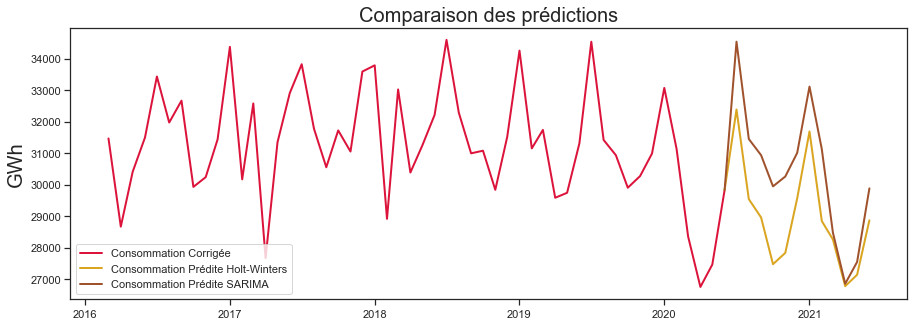

In [43]:
plt.figure(figsize=(15, 5))

# Prédictions des deux modèles:
plt.plot(df["consommation_corrigee"][50:], color="crimson", label="Consommation Corrigée", linewidth=2)
plt.plot(hw_serie, color="goldenrod", label="Consommation Prédite Holt-Winters", linewidth=2)
plt.plot(sarimadata["mean"], color="sienna", label="Consommation Prédite SARIMA", linewidth=2)

plt.title("Comparaison des prédictions", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend(loc="lower left")
plt.savefig("data/projet_9/graphiques/M3_IV_1_comparaison_previsions.png") ; plt.show()

 Le modèle SARIMA semble bien mieux suivre la tendance de la série temporelle des consommations corrigées que le modèle de Holt-Winters.

### M3.IV.2. Calcul des indicateurs a posteriori

 Nous allons maintenant comparer les prédictions a posteriori réalisées sur les deux modèles.

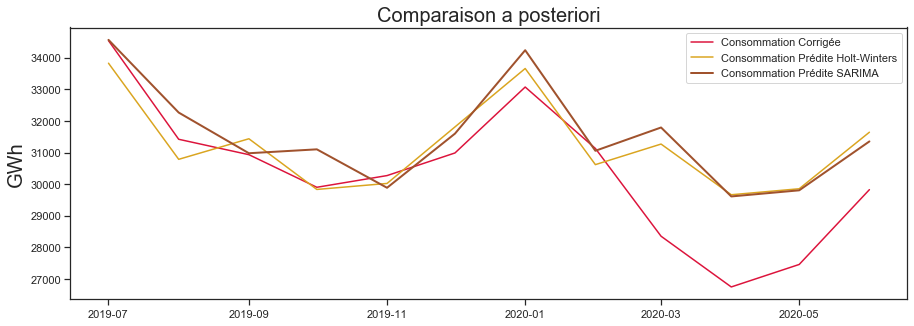

In [44]:
plt.figure(figsize=(15, 5))

plt.plot(df_a_prevoir, color="crimson", label="Consommation Corrigée")
plt.plot(hw_posteriori_serie, color="goldenrod", label="Consommation Prédite Holt-Winters")
plt.plot(sarima_previsions["mean"], color="sienna", label="Consommation Prédite SARIMA", linewidth=2)

plt.title("Comparaison a posteriori", fontsize=20), plt.ylabel("GWh", fontsize=20), plt.legend()
plt.savefig("data/projet_9/graphiques/M3_IV_2_comparaison_posteriori.png") ; plt.show()

  Il est difficile de comparer les erreurs quadratiques sur le graphique, __le confinement de mars - avril- mai 2020 crée une période "outlier" dans nos données__, nous ne prendrons donc en compte que janvier - février - mars pour ce comparatif. Calculons donc les MSE des deux modèles.

In [45]:
print("Holt-Winters - MSE = ", mean_squared_error(hw_posteriori_serie[:3],df_a_prevoir["consommation_corrigee"][:3]))
print("SARIMA - MSE = ", mean_squared_error(sarima_previsions["mean"][:3],df_a_prevoir["consommation_corrigee"][:3]))

Holt-Winters - MSE =  388809.13859766355
SARIMA - MSE =  239078.28877669488


 Nous relevons bien une prédiction plus proche de la réalité pour le modèle SARIMA que pour le modèle de Holt-Winter.

### M3.IV.3. Conclusion: Prédiction de la consommation électrique retenue

 En vertue des deux sous-parties précédentes, c'est donc finalemnent le modèle SARIMA que nous sélectionnerons pour une prédiction business sur les données de consommation électrique.

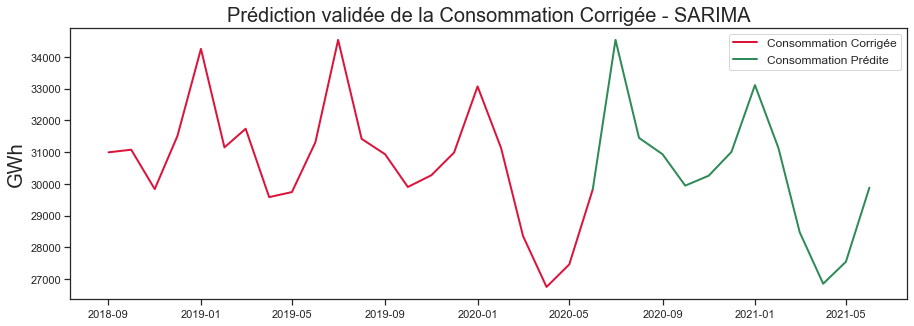

In [46]:
plt.figure(figsize=(15,5))

# Affichage des données de consommation corrigées (à partir de 2016 pour une meilleure visualisation des prévisions):
plt.plot(df["consommation_corrigee"][80:], color="crimson", label="Consommation Corrigée", linewidth=2)

# Affichage des prévisions des données de consommation selon SAR:
plt.plot(sarimadata["mean"], color="seagreen", label="Consommation Prédite", linewidth=2)

plt.title("Prédiction validée de la Consommation Corrigée - SARIMA", fontsize=20)
plt.ylabel("GWh", fontsize=20), plt.xlabel(""), plt.legend(loc="upper right", fontsize=12)
plt.savefig("data/projet_9/graphiques/M3_IV_F_prediction_finale.png") ; plt.show()